In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (accuracy_score,
                                classification_report,
                                confusion_matrix,
                                roc_auc_score, 
                                fbeta_score,
                                make_scorer, 
                                precision_recall_curve, 
                                average_precision_score)

import time
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

In [2]:
abt = pd.read_csv('analytical_base_table.csv')

In [3]:
y = abt.bad_flag
X = abt.drop('bad_flag', axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1234,
    stratify=abt.bad_flag
)

print(len(X_train), len(X_test), len(y_train), len(y_test))

3324 832 3324 832


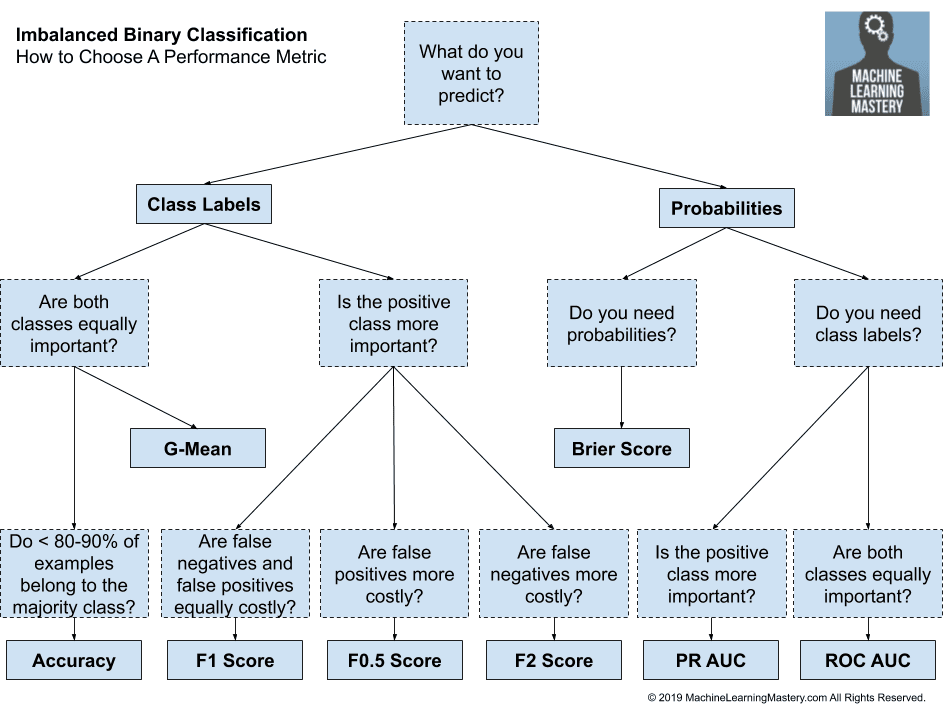

In [5]:
display(Image(filename='imbalanced_class.png', width=600))

In [6]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight =", scale_pos_weight)   

scale_pos_weight = 8.952095808383234


In [7]:
models = {
    'xgb': XGBClassifier(
        random_state=123, 
        verbose=0,
        scale_pos_weight=scale_pos_weight,
        eval_metric='aucpr',
        three_metod='hist',
        use_label_encoder=False
    ),
    'lgb': LGBMClassifier(
        random_state=123, 
        scale_pos_weight=scale_pos_weight,
        metric='auc',   
        verbose=-1
    ),
    'cat': CatBoostClassifier(
        random_state=123, 
        class_weights=[1, scale_pos_weight],
        eval_metric='PRAUC',  
        thread_count=-1,
        verbose=0
    )
}


In [8]:
hyperparameters = {
    'xgb': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.2]
    },
    'lgb': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.2]
    },
    'cat': {
        'iterations': [100, 200],
        'depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.2],
    }
}


In [9]:

fitted_models = {}

for name, model in models.items():
    start = time.time()
    
    rs = RandomizedSearchCV(
        model,
        hyperparameters[name],
        n_iter=10,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    rs.fit(X_train, y_train)
    
    end = time.time()
    elapsed = end - start

    fitted_models[name] = rs
    print(f"{name} Training time: {elapsed:.2f} sec\n")
    best_model = rs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.3f}\n")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred), "\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60, "\n")


xgb Training time: 4.53 sec

AUC: 0.827

Confusion Matrix:
[[572 177]
 [ 21  62]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       749
           1       0.26      0.75      0.39        83

    accuracy                           0.76       832
   macro avg       0.61      0.76      0.62       832
weighted avg       0.89      0.76      0.81       832

------------------------------------------------------------ 

lgb Training time: 21.18 sec

AUC: 0.824

Confusion Matrix:
[[572 177]
 [ 19  64]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       749
           1       0.27      0.77      0.40        83

    accuracy                           0.76       832
   macro avg       0.62      0.77      0.62       832
weighted avg       0.90      0.76      0.81       832

------------------------------------------------------------ 

cat T


Model: XGB
Optimal threshold: 0.468
Max F2: 0.576
[[536 213]
 [ 12  71]]
              precision    recall  f1-score   support

           0      0.978     0.716     0.827       749
           1      0.250     0.855     0.387        83

    accuracy                          0.730       832
   macro avg      0.614     0.786     0.607       832
weighted avg      0.905     0.730     0.783       832


Model: LGB
Optimal threshold: 0.477
Max F2: 0.570
[[552 197]
 [ 15  68]]
              precision    recall  f1-score   support

           0      0.974     0.737     0.839       749
           1      0.257     0.819     0.391        83

    accuracy                          0.745       832
   macro avg      0.615     0.778     0.615       832
weighted avg      0.902     0.745     0.794       832


Model: CAT
Optimal threshold: 0.455
Max F2: 0.563
[[522 227]
 [ 12  71]]
              precision    recall  f1-score   support

           0      0.978     0.697     0.814       749
           1   

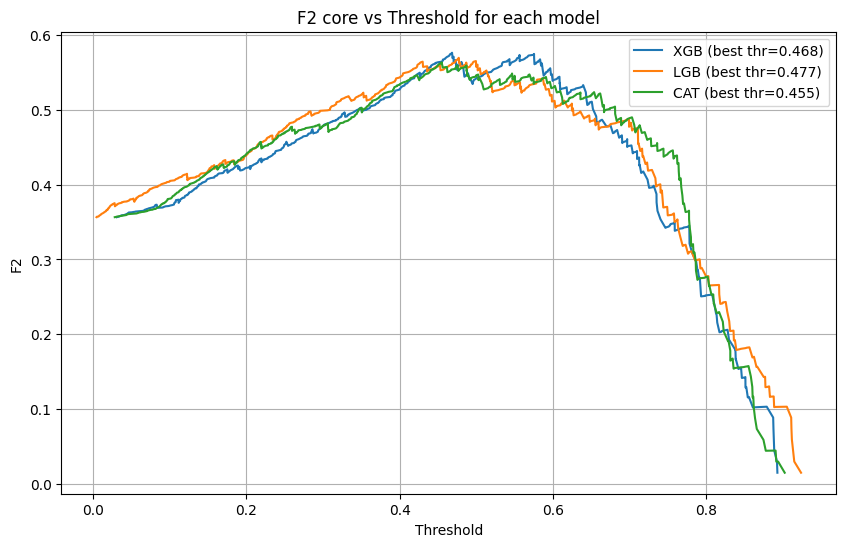

In [10]:
beta = 2
fitted_models_results = {}

plt.figure(figsize=(10, 6))

for i, (name, rs) in enumerate(fitted_models.items(), start=1):
    best_model = rs.best_estimator_
    y_scores = best_model.predict_proba(X_test)[:, 1]
    
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    f2_scores = (1 + beta**2) * (precisions[:-1] * recalls[:-1]) / ((beta**2) * precisions[:-1] + recalls[:-1] + 1e-10)
    
    best_idx = np.argmax(f2_scores)
    best_threshold = thresholds[best_idx]
    best_f2 = f2_scores[best_idx]
    
    y_pred_opt = (y_scores >= best_threshold).astype(int)
    
    fitted_models_results[name] = {
        'best_threshold': best_threshold,
        'best_f2': best_f2,
        'y_pred_opt': y_pred_opt
    }
    
    print(f"\nModel: {name.upper()}")
    print(f"Optimal threshold: {best_threshold:.3f}")
    print(f"Max F2: {best_f2:.3f}")
    print(confusion_matrix(y_test, y_pred_opt))
    print(classification_report(y_test, y_pred_opt, digits=3))
    
    plt.plot(thresholds, f2_scores, label=f"{name.upper()} (best thr={best_threshold:.3f})")

plt.title("F2 core vs Threshold for each model")
plt.xlabel("Threshold")
plt.ylabel("F2")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# optimize the probability threshold that we use to predict the class (0.5 is not the one).
# combine a threshold dependent and a threshold independent metric to evaluate model performance.
# Adjust the probability threshold when calculating the threshold dependent metric
# Do use cost sensitive learning

In [14]:

final_model = XGBClassifier(
    random_state=123,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    tree_method='hist'
)
final_model.fit(X_train, y_train)


y_proba = final_model.predict_proba(X_test)[:, 1]

threshold = 0.468
y_pred_final = (y_proba >= threshold).astype(int)


print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))


[[665  84]
 [ 51  32]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       749
           1       0.28      0.39      0.32        83

    accuracy                           0.84       832
   macro avg       0.60      0.64      0.61       832
weighted avg       0.86      0.84      0.85       832

